## Content

1. [Methods](#Methods)
2. [FVA and AVA](#FVA-and-AVA)

    2.1 [Black-Scholes](#Black-Scholes)

    2.2 [Classical Monte Carlo](#Classical-Monte-Carlo)
    
    2.3 [Quantum Monte Carlo](#Quantum-Monte-Carlo)


## Methods

In [232]:
import numpy as np
import datetime as dt
import scipy.stats as st
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation 

The underlyng dynamics of $S(t)$ under the risk-free measure with dividend yield $d$ is
    $$dS(t) = (r-q) S(t)dt + \sigma S(t) dW^{\mathbb{Q}}(t)\,,$$
and the BS formula for a European option can be defined as 
$$V(t,S) = \delta S(t) \mathrm{e}^{-q(T-t)} \Phi\left(\delta d_1\right) - \delta\mathrm{e}^{-r(T-t)}K\Phi\left( \delta d_2\right),$$
where 
$$d_1 = \left(\ln(S(t)/K) + (r + 0.5\sigma^2)(T-t) \right) / \sigma \sqrt{T-t}, \quad d_2 = d_1 - \sigma \sqrt{T-t} \quad \text{and} \quad \Phi(\,.\,)$$
is the standard Gauss-Laplace cumulative distribution function (CDF), and $\delta = 1$ if it is a call option and -1 if it is a put option.

In [233]:
def black_scholes_european_option(initial_price, dividends_rate, risk_free_rate, volatility, initial_time, strike, expiry_date, type):
    """
    Black Scholes formula for European call or put option premium, where the underlying 
    follows a geometric Brownian motion (GBM) with constant parameters.

    Parameters
    ----------
    initial_price: float
    dividends_rate: float
    risk_free_rate: float
    volatility: float
    strike: float
    initial_time: float
    expiry_date: float
    type: int
        1 for call option and -1 for put option

    Returns
    -------
    option_premium: float
    """

    drift = risk_free_rate - dividends_rate
    d1 = (np.log(initial_price / strike) + (drift + 0.5 * volatility**2) * (expiry_date - initial_time)) / (volatility * np.sqrt(expiry_date - initial_time))
    d2 = d1 - volatility * np.sqrt(expiry_date - initial_time)

    phi1 = st.norm.cdf(type * d1)
    phi2 = st.norm.cdf(type * d2)

    option_premium = type * initial_price * np.exp(-dividends_rate * (expiry_date - initial_time)) * phi1  - type * np.exp(-risk_free_rate * (expiry_date - initial_time)) * strike * phi2  
    
    return option_premium



For simulating the stock price, we can use the exact solution of the GBM, i.e.,
$$S(T) = S(t) \mathrm{e}^{\left(r - q -\frac{1}{2}\sigma^{2}\right)(T-t)+\sigma \sqrt{T-t} Z}\,,$$
where $Z$ follows a standard Gauss-Laplace distribution. 

In [234]:
def classical_monte_carlo_gmb(nb_simulations, initial_price, drift, volatility, initial_time, expiry_date, seed):
    """
    Classical Monte Carlo simulation where the underlying follows a geometric Brownian motion (GBM) with constant parameters.

    Parameters
    nb_simulations: int
    initial_price: float
    drift: float
    volatility: float
    initial_time: float
    expiry_date: float
    seed: int


    Returns
    results: list
    """
    
    results = []
    np.random.seed(seed)
    for i in range(0, nb_simulations):  
        
        increment = 1
        steps = round((expiry_date-initial_time)/increment)
        random_variables = np.random.normal(0, 1, steps)
        time_discretization = np.linspace(0, (expiry_date-initial_time), steps)
        brownian_motions = np.cumsum(random_variables) * np.sqrt(increment)
        geometric_brownian_motions = (drift - 0.5 * volatility ** 2) * time_discretization + volatility * brownian_motions
        simulated_prices = initial_price * np.exp(geometric_brownian_motions)        
        results.append(simulated_prices[-1])

    return results


def discounted_european_payoff(simulation, risk_free_rate, strike, initial_time, expiry_date, type):
    """
    European option premium calculation from simulated prices.

    Parameters
    simulation: list
    risk_free_rate: float
    strike: strike
    initial_time: float
    expiry_date: float
    
    Returns
    option_premium_approximation: float
    """
    payoff = lambda s: max(s - strike, 0) if type == 1 else min(strike - s, 0) 
    simulated_payoff = [payoff(s) for s in simulation]

    option_premium_approximation = np.exp(-risk_free_rate * (expiry_date - initial_time)) * np.average(simulated_payoff)

    return option_premium_approximation
    

## FVA and AVA

In [235]:
initial_price = 60
dividends = [0.0, 0.02, 0.02 + 0.0075, 0.02 + 0.0075 * 2, 0.02 + 0.0075 * 3, 0.02 + 0.0075 * 4]
risk_free_rate = 0.05
volatility = 0.2
strike = 65
initial_time = 0
expiry_date = 5
type = 1
nb_options = 500

seed = 5
dec_prec = 2

### Black-Scholes

In [236]:
df_results = pd.DataFrame()
for d in range(0, len(dividends)):
    
    begin = dt.datetime.now()
    exact_option_premium = black_scholes_european_option(
                                                        initial_price,
                                                        dividends[d], 
                                                        risk_free_rate,
                                                        volatility,
                                                        initial_time,
                                                        strike, 
                                                        expiry_date, 
                                                        type)

    df_results.loc[d, 'Dividend'] = dividends[d]
    df_results.loc[d, 'BS'] = exact_option_premium

df_results

,Dividend,BS
0,0.0000,15.160246
1,0.0200,11.226911
2,0.0275,9.963217
3,0.0350,8.807617
4,0.0425,7.755144
5,0.0500,6.800612


In [237]:
npv = df_results.loc[df_results['Dividend'] == 0.0, ['BS']].values[-1]
fv = df_results.loc[df_results['Dividend'] == 0.02, ['BS']].values[-1]
fva = round(npv[0], dec_prec) - round(fv[0], dec_prec) 
print(f"FVA = {nb_options} * ({str(round(npv[0], dec_prec))} - {str(round(fv[0], dec_prec))}) = {nb_options * fva} EUR")

FVA = 500 * (15.16 - 11.23) = 1964.9999999999998 EUR


In [238]:
pv = np.percentile(df_results.loc[df_results['Dividend'] > 0.02, ['BS']].reset_index(drop=True), 1)
ava =  round(fv[0], dec_prec) - round(pv, dec_prec)
print(f"AVA = {nb_options} * ({str(round(fv[0], dec_prec))} - {str(round(pv, dec_prec))}) = {nb_options * ava} EUR")

AVA = 500 * (11.23 - 6.83) = 2200.0 EUR


### Classical Monte Carlo

In [239]:
df_mc_results = pd.DataFrame()
for nb_sim in [10**5]:
    for d in range(0, len(dividends)):
        
        mu = risk_free_rate - dividends[d]
        begin = dt.datetime.now()
        simulations_results = classical_monte_carlo_gmb(
                                                        nb_sim,
                                                        initial_price,
                                                        mu,
                                                        volatility,
                                                        initial_time, 
                                                        expiry_date,
                                                        seed=4)
        approx_option_premium = discounted_european_payoff(
                                                        simulations_results,
                                                        risk_free_rate, strike, 
                                                        initial_time, 
                                                        expiry_date, 
                                                        type)
        end = dt.datetime.now()
        
        df_mc_results.loc[d, 'Dividend'] = dividends[d]
        df_mc_results.loc[d, f'MC {nb_sim}'] = approx_option_premium
        df_mc_results.loc[d, f'MC {nb_sim} Error'] = approx_option_premium - df_results.loc[d, 'BS']
        df_mc_results.loc[d, f'MC TTS {nb_sim}'] = f"{(end - begin).seconds}"

df_mc_results

,Dividend,MC 100000,MC 100000 Error,MC TTS 100000
0,0.0000,15.028816,-0.131430,1
1,0.0200,11.124332,-0.102579,1
2,0.0275,9.870316,-0.092901,1
3,0.0350,8.722780,-0.084837,1
4,0.0425,7.678007,-0.077137,1
5,0.0500,6.730220,-0.070392,1


In [240]:
mc_sample = 'MC 100000'
df_mc_results[f'{mc_sample} Error'].apply(lambda x: np.format_float_scientific(x))

0     -1.314300695857309e-01
1    -1.0257868998847819e-01
2     -9.290104179470404e-02
3     -8.483729684221686e-02
4     -7.713699107882199e-02
5     -7.039245813195194e-02
Name: MC 100000 Error, dtype: object

In [241]:
mc_npv = df_mc_results.loc[df_mc_results['Dividend'] == 0.0, [f'{mc_sample}']].values[-1]
mc_fv = df_mc_results.loc[df_mc_results['Dividend'] == 0.02, [f'{mc_sample}']].values[-1]
mc_fva = round(mc_npv[0], dec_prec) - round(mc_fv[0], dec_prec) 

print(f"MC FVA = {nb_options} * ({round(mc_npv[0], dec_prec)} - {round(mc_fv[0], dec_prec)}) = {nb_options * mc_fva} EUR")

print(f"MC FVA Error = {nb_options} * ({mc_fva} - {fva}) = {nb_options * (mc_fva - fva)} EUR")

MC FVA = 500 * (15.03 - 11.12) = 1955.0 EUR
MC FVA Error = 500 * (3.91 - 3.9299999999999997) = -9.999999999999787 EUR


In [242]:
mc_pv = np.percentile(df_mc_results.loc[df_results['Dividend'] > 0.02, [f'{mc_sample}']].reset_index(drop=True), 1)
mc_ava = round(mc_fv[0], dec_prec) - round(mc_pv, dec_prec)

print(f"MC AVA = {nb_options} * ({str(round(mc_fv[0], dec_prec))} - {str(round(mc_pv, dec_prec))}) = {nb_options * mc_ava} EUR")


print(f"MC AVA Error = {nb_options} * ({mc_ava} - {ava}) = {nb_options * (mc_ava - ava)} EUR")

MC AVA = 500 * (11.12 - 6.76) = 2179.9999999999995 EUR
MC AVA Error = 500 * (4.359999999999999 - 4.4) = -20.000000000000462 EUR


### Quantum Monte Carlo

In [243]:
num_qubits = 3

df_approx = pd.DataFrame()
for d in range(0, len(dividends)):

    drift = risk_free_rate - dividends[d]
    mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
    sigma = volatility * np.sqrt(expiry_date - initial_time)
    mean = np.exp(mu + 0.5 * sigma**2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    std_scaling = np.arange(3, 9.5, 0.5).tolist()

    for i in range(0, len(std_scaling)):
        
        low = np.maximum(0, mean - std_scaling[i] * stddev)
        high = mean + std_scaling[i] * stddev

        uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
        x = uncertainty_model.values
        y = uncertainty_model.probabilities
        v = [max(i - strike, 0) * j for i,j in zip(x,y)]
        premium_approximation = np.exp(-risk_free_rate * (expiry_date - initial_time)) * sum(v)

        df_approx.loc[i, f"Std scaling"] = round(std_scaling[i],4)
        df_approx.loc[i, f"{round(dividends[d], 4)}"] = premium_approximation
        df_approx.loc[i, f"{round(dividends[d], 4)} abs. error"] = abs(df_results.loc[df_results['Dividend'] ==  dividends[d], ['BS']].values[-1][0] - premium_approximation)


In [244]:
df_best_approx = pd.DataFrame()
for d in range(0, len(dividends)):

    drift = risk_free_rate - dividends[d]
    mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
    sigma = volatility * np.sqrt(expiry_date - initial_time)
    mean = np.exp(mu + 0.5 * sigma**2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    std_min = df_approx.loc[df_approx[f"{round(dividends[d], 4)} abs. error"] == min(df_approx[f"{round(dividends[d], 4)} abs. error"]), ["Std scaling"]].values[-1][0]
    std_max = std_min + 1

    std_scaling = np.arange(std_min - 0.5, std_max, 0.005).tolist()
    for i in range(0, len(std_scaling)):
        
        low = np.maximum(0, mean - std_scaling[i] * stddev)
        high = mean + std_scaling[i] * stddev

        uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
        x = uncertainty_model.values
        y = uncertainty_model.probabilities
        v = [max(i - strike, 0) * j for i,j in zip(x,y)]
        premium_approximation = np.exp(-risk_free_rate * (expiry_date - initial_time)) * sum(v)

        df_best_approx.loc[i, f"{round(dividends[d], 4)} std scaling"] = round(std_scaling[i],4)
        df_best_approx.loc[i, f"{round(dividends[d], 4)}"] = premium_approximation
        df_best_approx.loc[i, f"{round(dividends[d], 4)} abs. error"] = abs(df_results.loc[df_results['Dividend'] ==  dividends[d], ['BS']].values[-1][0] - premium_approximation)

In [245]:
df_discrete_results = pd.DataFrame()
for d in range(0, len(dividends)):

    df_discrete_results.loc[d, 'Dividend'] =  dividends[d]

    df_discrete_results.loc[d, 'Std scale'] =  df_best_approx.loc[
        df_best_approx[f"{round(dividends[d], 4)} abs. error"] == min(df_best_approx[f"{round(dividends[d], 4)} abs. error"]), [f"{round(dividends[d], 4)} std scaling"]].values[-1]
    
    df_discrete_results.loc[d, 'Approx.'] =  df_best_approx.loc[
        df_best_approx[f"{round(dividends[d], 4)} abs. error"] == min(df_best_approx[f"{round(dividends[d], 4)} abs. error"]), [f"{round(dividends[d], 4)}"]].values[-1]
    
    df_discrete_results.loc[d, 'Approx. Error'] =   df_results.loc[d, 'BS'] - df_discrete_results.loc[d, 'Approx.']

In [246]:
df_discrete_results

,Dividend,Std scale,Approx.,Approx. Error
0,0.0000,6.310,15.160265,-0.000019
1,0.0200,7.005,11.226833,0.000078
2,0.0275,7.330,9.963601,-0.000384
3,0.0350,6.830,8.807453,0.000164
4,0.0425,8.165,7.755646,-0.000502
5,0.0500,7.430,6.800655,-0.000043


In [247]:
df_discrete_results['Approx. Error'].apply(lambda x: np.format_float_scientific(x))

0    -1.8650466710568026e-05
1      7.771115048527122e-05
2     -3.841183601078768e-04
3     1.6378896340896176e-04
4     -5.018297876224764e-04
5     -4.275660546770865e-05
Name: Approx. Error, dtype: object

In [248]:
app_npv = df_discrete_results.loc[df_discrete_results['Dividend'] == 0.0, ['Approx.']].values[-1]
app_fv = df_discrete_results.loc[df_discrete_results['Dividend'] == 0.02, ['Approx.']].values[-1]
app_fva = round(app_npv[0], dec_prec) - round(app_fv[0], dec_prec)

print(f"Approx. FVA = {nb_options} * ({round(app_fv[0], dec_prec)} - {round(app_npv[0], dec_prec)}) = {nb_options * round(app_fva, dec_prec)} EUR")

print(f"Approx. FVA Error = {nb_options} * ({app_fva} - {fva}) = {nb_options * (app_fva - fva)} EUR")

Approx. FVA = 500 * (11.23 - 15.16) = 1965.0 EUR
Approx. FVA Error = 500 * (3.9299999999999997 - 3.9299999999999997) = 0.0 EUR


In [249]:
app_pv = np.percentile(df_discrete_results.loc[df_discrete_results['Dividend'] > 0.02, ['Approx.']].reset_index(drop=True), 1)
app_ava = round(app_fv[0], dec_prec) - round(app_pv, dec_prec)

print(f"Approx. AVA = {nb_options} * ({round(app_fv[0], dec_prec)} - {round(app_pv, dec_prec)}) = {nb_options *  round(app_ava, dec_prec)} EUR")

print(f"Approx. AVA Error = {nb_options} * ({app_ava} - {ava}) = {nb_options * (app_ava - ava)} EUR")

Approx. AVA = 500 * (11.23 - 6.83) = 2200.0 EUR
Approx. AVA Error = 500 * (4.4 - 4.4) = 0.0 EUR


Maximum Likelihood Quantum Amplitude Estimation

In [250]:
eval = 4
shots = 1000

In [251]:
df_mlqae_results = pd.DataFrame()
for d, s, v in zip(list(df_discrete_results['Dividend']), list(df_discrete_results['Std scale']), list(df_discrete_results['Approx.'])):

    drift = risk_free_rate - d
    mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
    sigma = volatility * np.sqrt(expiry_date - initial_time)
    mean = np.exp(mu + 0.5 * sigma**2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)
    low = np.maximum(0, mean - s * stddev)
    high = mean + s * stddev

    uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
    
    mlqae = MaximumLikelihoodAmplitudeEstimation(
                                                evaluation_schedule=eval,
                                                sampler=Sampler(options={"shots": shots, "seed": seed}))
    
    discount_factor = np.exp(-risk_free_rate * (expiry_date - initial_time))
    
    c_scaling= np.arange(0.1, 0.5, 0.1).tolist()
    for j in range(0, len(c_scaling)):
        
        european_call_pricing = EuropeanCallPricing(
                                                    num_state_qubits=num_qubits,
                                                    strike_price=strike,
                                                    rescaling_factor=c_scaling[j],
                                                    bounds=(low, high),
                                                    uncertainty_model=uncertainty_model)
        
        problem = european_call_pricing.to_estimation_problem()
        mlqae_result = mlqae.estimate(problem)
        
        df_mlqae_results.loc[j, 'Scaling'] = c_scaling[j]        
        df_mlqae_results.loc[j, f"MLQAE {round(d, 4)}"] =  discount_factor * european_call_pricing.interpret(mlqae_result)
        df_mlqae_results.loc[j, f"MLQAE {round(d, 4)} Error"] =  abs(v - df_mlqae_results.loc[j,f"MLQAE {round(d, 4)}"])


In [252]:
df_best_c_range = pd.DataFrame()
for d, s, v in zip(list(df_discrete_results['Dividend']), list(df_discrete_results['Std scale']), list(df_discrete_results['Approx.'])):

    drift = risk_free_rate - d
    mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
    sigma = volatility * np.sqrt(expiry_date - initial_time)
    mean = np.exp(mu + 0.5 * sigma**2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)
    low = np.maximum(0, mean - s * stddev)
    high = mean + s * stddev

    uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
    
    mlqae = MaximumLikelihoodAmplitudeEstimation(
                                                evaluation_schedule=eval,
                                                sampler=Sampler(options={"shots": shots, "seed": seed}))
    
    discount_factor = np.exp(-risk_free_rate * (expiry_date - initial_time))
    
    c_min = df_mlqae_results.loc[df_mlqae_results[f"MLQAE {round(d, 4)} Error"] == min(df_mlqae_results[f"MLQAE {round(d, 4)} Error"]), ["Scaling"]].values[-1][0]
    c_max = c_min + 0.1
    
    c_scaling= np.arange(max(c_min - 0.1, 0.01), c_max, 0.01).tolist()
    for j in range(0, len(c_scaling)):
        
        european_call_pricing = EuropeanCallPricing(
                                                    num_state_qubits=num_qubits,
                                                    strike_price=strike,
                                                    rescaling_factor=c_scaling[j],
                                                    bounds=(low, high),
                                                    uncertainty_model=uncertainty_model)
        
        problem = european_call_pricing.to_estimation_problem()
        
        begin = dt.datetime.now()
        mlqae_result = mlqae.estimate(problem)
        mlqae_premium = discount_factor * european_call_pricing.interpret(mlqae_result)
        end = dt.datetime.now()

        df_best_c_range.loc[j, f"MLQAE {round(d, 4)} scaling"] = c_scaling[j]        
        df_best_c_range.loc[j, f"MLQAE {round(d, 4)}"] = mlqae_premium 
        df_best_c_range.loc[j, f"MLQAE {round(d, 4)} Error"] =  abs(v - df_best_c_range.loc[j,f"MLQAE {round(d, 4)}"])
        df_best_c_range.loc[j, f"MLQAE {round(d, 4)} TTS"] =  f"{(end - begin).seconds}"

In [253]:
df_qmc_results = pd.DataFrame()
for d in range(0, len(dividends)):

    df_qmc_results.loc[d, 'Dividend'] =  dividends[d]

    df_qmc_results.loc[d, 'c'] =  df_best_c_range.loc[
        df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"] == min(df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"]), [f"MLQAE {round(dividends[d], 4)} scaling"]].values[-1]
    
    df_qmc_results.loc[d, 'MLQAE'] =  df_best_c_range.loc[
        df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"] == min(df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"]), [f"MLQAE {round(dividends[d], 4)}"]].values[-1]
    
    df_qmc_results.loc[d, 'MLQAE Error'] = df_discrete_results.loc[d, 'Approx.'] - df_qmc_results.loc[d, 'MLQAE'] 
    
    df_qmc_results.loc[d, 'MLQAE TTS'] =  df_best_c_range.loc[
        df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"] == min(df_best_c_range[f"MLQAE {round(dividends[d], 4)} Error"]), [f"MLQAE {round(dividends[d], 4)} TTS"]].values[-1]

df_qmc_results

,Dividend,c,MLQAE,MLQAE Error,MLQAE TTS
0,0.0000,0.11,15.132408,0.027856,2
1,0.0200,0.09,11.265194,-0.038361,2
2,0.0275,0.11,10.066100,-0.102499,2
3,0.0350,0.11,8.879512,-0.072058,2
4,0.0425,0.10,7.683764,0.071882,2
5,0.0500,0.20,6.850245,-0.049590,2


In [254]:
df_qmc_results['MLQAE Error'].apply(lambda x: np.format_float_scientific(x))

0      2.785620828704083e-02
1     -3.836122629668104e-02
2    -1.0249926565364298e-01
3     -7.205841754370468e-02
4      7.188156382964284e-02
5     -4.958964949497524e-02
Name: MLQAE Error, dtype: object

In [255]:
qmc_npv = df_qmc_results.loc[df_qmc_results['Dividend'] == 0.0, ['MLQAE']].values[-1]
qmc_fv = df_qmc_results.loc[df_qmc_results['Dividend'] == 0.02, ['MLQAE']].values[-1]
qmc_fva = round(qmc_npv[0], dec_prec) - round(qmc_fv[0], dec_prec)

print(f"MLQAE FVA = {nb_options} * ({round(qmc_npv[0], dec_prec)} - {round(qmc_fv[0], dec_prec)}) = {nb_options * round(qmc_fva, dec_prec)} EUR")

print(f"MLQAE FVA Error = {nb_options} * ({qmc_fva} - {app_fva}) = {nb_options * (qmc_fva - app_fva)} EUR")

MLQAE FVA = 500 * (15.13 - 11.27) = 1930.0 EUR
MLQAE FVA Error = 500 * (3.860000000000001 - 3.9299999999999997) = -34.999999999999254 EUR


In [256]:
qmc_pv = np.percentile(df_qmc_results.loc[df_qmc_results['Dividend'] > 0.02, ['MLQAE']].reset_index(drop=True), 1)
qmc_ava = round(qmc_fv[0], dec_prec) - round(qmc_pv, dec_prec)

print(f"MLQAE AVA = {nb_options} * ({round(qmc_fv[0], dec_prec)} - {round(qmc_pv, dec_prec)}) = {nb_options *  qmc_ava} EUR")

print(f"MLQAE AVA Error = {nb_options} * ({qmc_ava} - {app_ava}) = {nb_options * (qmc_ava - app_ava)} EUR")

MLQAE AVA = 500 * (11.27 - 6.88) = 2195.0 EUR
MLQAE AVA Error = 500 * (4.39 - 4.4) = -5.0000000000003375 EUR


In [268]:
eval = 4
shots_list = [10**4, 10**5, 10**6] 
df_shots = pd.DataFrame()
for n in range(0, len(shots_list)):
    
    df_shots.loc[n, f"Shots"] = shots_list[n] 

    for d, s, v, c in zip(list(df_discrete_results['Dividend']), list(df_discrete_results['Std scale']), list(df_discrete_results['Approx.']), df_qmc_results['c']):

        drift = risk_free_rate - d
        mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
        sigma = volatility * np.sqrt(expiry_date - initial_time)
        mean = np.exp(mu + 0.5 * sigma**2)
        variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
        stddev = np.sqrt(variance)
        low = np.maximum(0, mean - s * stddev)
        high = mean + s * stddev

        uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
        
        mlqae = MaximumLikelihoodAmplitudeEstimation(
                                                evaluation_schedule=eval, 
                                                sampler=Sampler(options={"shots": shots_list[n], "seed": 0}))
        
        discount_factor = np.exp(-risk_free_rate * (expiry_date - initial_time))

        
        european_call_pricing = EuropeanCallPricing(
                                                    num_state_qubits=num_qubits,
                                                    strike_price=strike,
                                                    rescaling_factor=c,
                                                    bounds=(low, high),
                                                    uncertainty_model=uncertainty_model)
            
        problem = european_call_pricing.to_estimation_problem()
            
        begin = dt.datetime.now()
        mlqae_result = mlqae.estimate(problem)
        mlqae_premium = discount_factor * european_call_pricing.interpret(mlqae_result)
        end = dt.datetime.now()
               
        df_shots.loc[n, f"MLQAE {round(d, 4)}"] = mlqae_premium 
        df_shots.loc[n, f"MLQAE {round(d, 4)} Error"] =  v - df_shots.loc[n, f"MLQAE {round(d, 4)}"]
        df_shots.loc[n, f"MLQAE {round(d, 4)} TTS"] =  f"{(end - begin).seconds}"

In [269]:
df_qmc_errors = df_shots.filter(regex='Error')
df_qmc_errors = df_qmc_errors.set_index(df_shots['Shots'])

In [270]:
columns_name = [f"$d={col.split()[1]}$" for col in df_qmc_errors.columns]

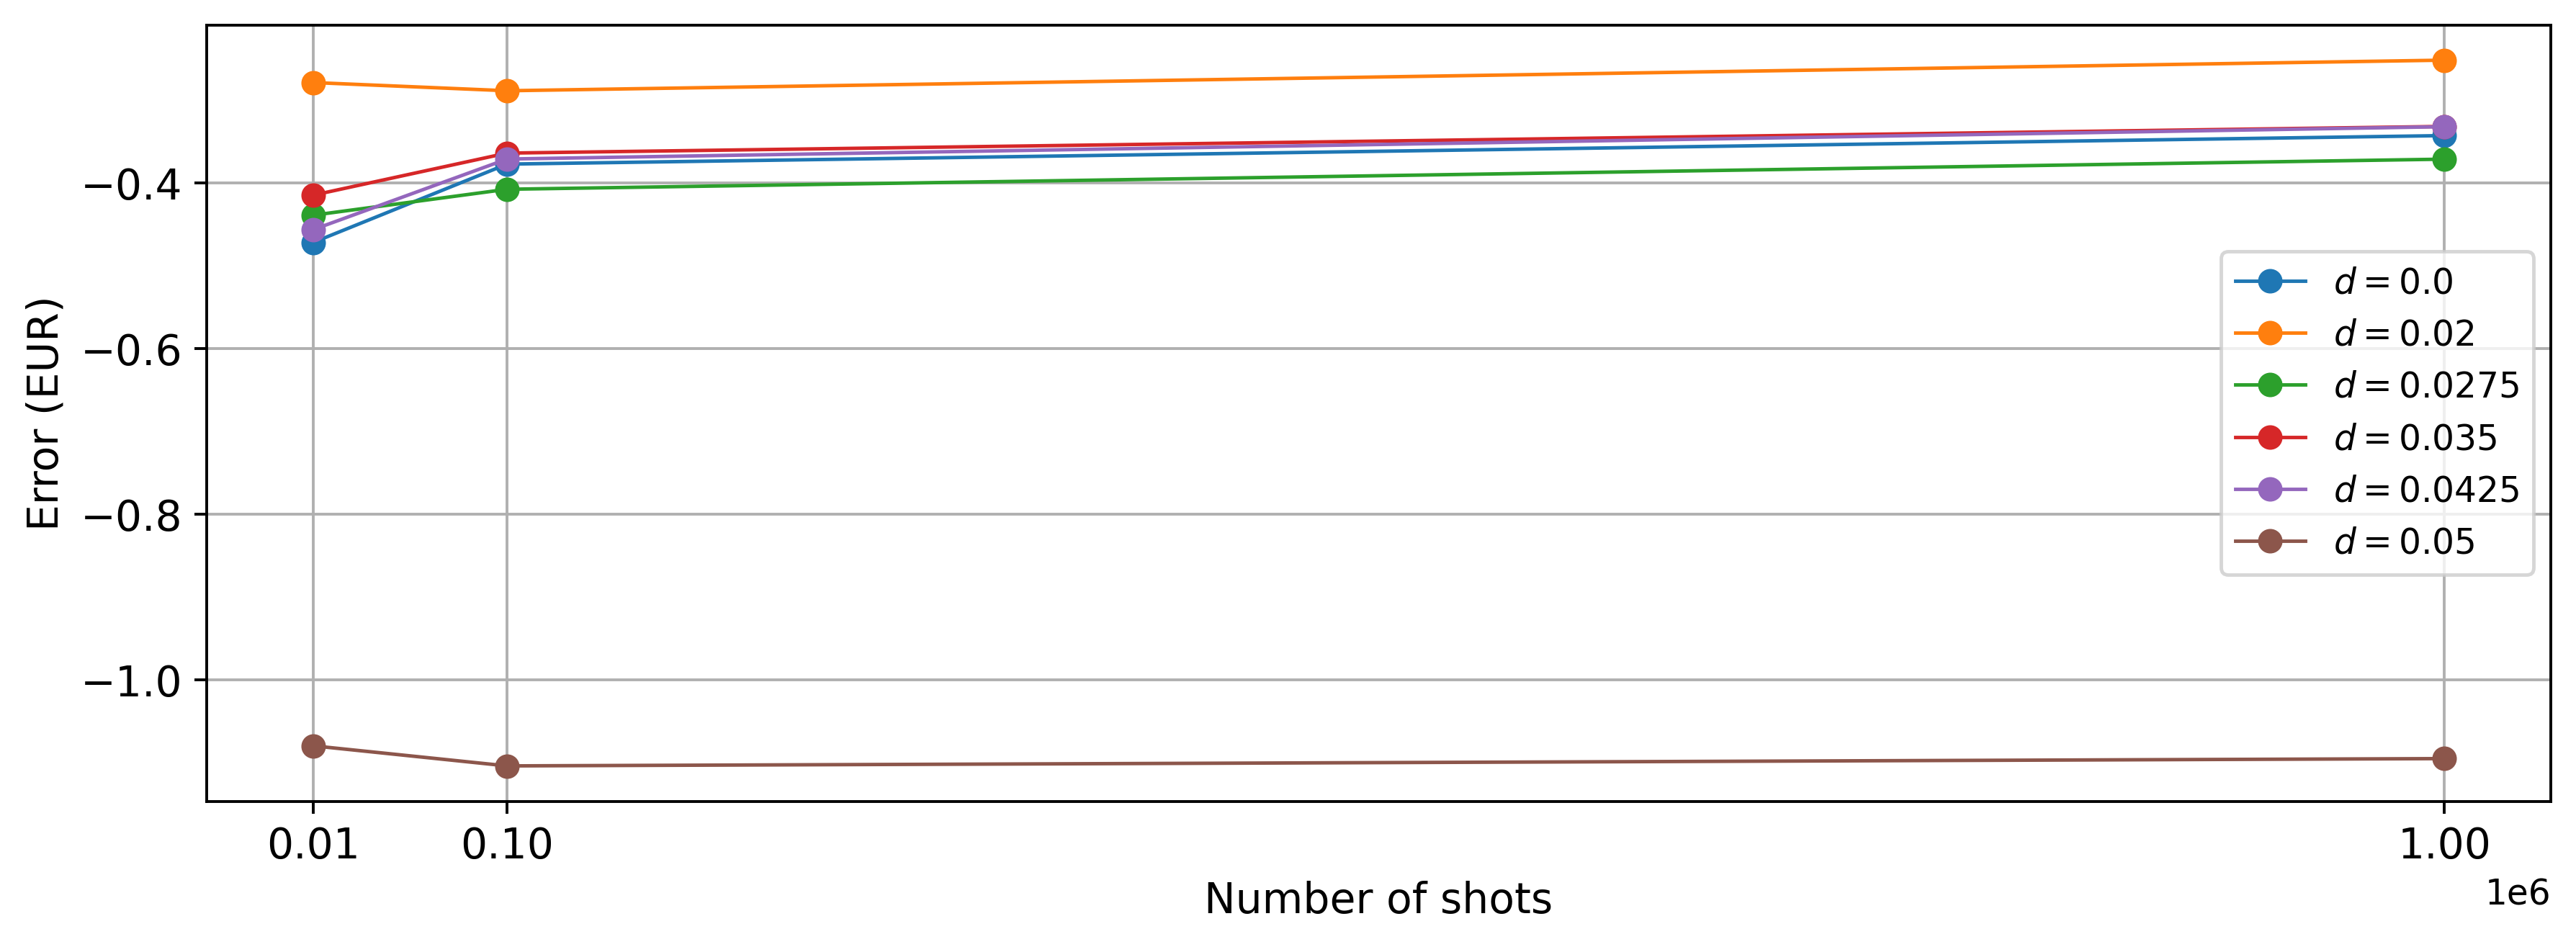

In [271]:
df_qmc_errors.columns = columns_name
fig, axs = plt.subplots(figsize=(12, 4), dpi=350)
df_qmc_errors.plot(ax=axs, marker='o', markersize=6, linewidth=1, alpha=1)
axs.grid(True)
axs.tick_params(axis='both', labelsize=12)
axs.set_xticks(df_qmc_errors.index)
axs.set_ylabel("Error (EUR)", fontsize=12)
axs.set_xlabel("Number of shots",  fontsize=12)
plt.show()

In [261]:
shots = 10**3 
eval_list = [4, 5, 6] 
df_eval = pd.DataFrame()
for e in range(0, len(eval_list)):
    
    df_eval.loc[e, "m"] = eval_list[e] 

    for d, s, v, c in zip(list(df_discrete_results['Dividend']), list(df_discrete_results['Std scale']), list(df_discrete_results['Approx.']), df_qmc_results['c']):

        drift = risk_free_rate - d
        mu = (drift - 0.5 * volatility**2) * (expiry_date - initial_time) + np.log(initial_price)
        sigma = volatility * np.sqrt(expiry_date - initial_time)
        mean = np.exp(mu + 0.5 * sigma**2)
        variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
        stddev = np.sqrt(variance)
        low = np.maximum(0, mean - s * stddev)
        high = mean + s * stddev

        uncertainty_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
        
        mlqae = MaximumLikelihoodAmplitudeEstimation(
                                                    evaluation_schedule=eval_list[e],  
                                                    sampler=Sampler(options={"shots": shots, "seed": seed}))
        
        discount_factor = np.exp(-risk_free_rate * (expiry_date - initial_time))

        
        european_call_pricing = EuropeanCallPricing(
                                                    num_state_qubits=num_qubits,
                                                    strike_price=strike,
                                                    rescaling_factor=c,
                                                    bounds=(low, high),
                                                    uncertainty_model=uncertainty_model)
            
        problem = european_call_pricing.to_estimation_problem()
            
        begin = dt.datetime.now()
        mlqae_result = mlqae.estimate(problem)
        mlqae_premium = discount_factor * european_call_pricing.interpret(mlqae_result)
        end = dt.datetime.now()
               
        df_eval.loc[e, f"MLQAE {round(d, 4)}"] = mlqae_premium 
        df_eval.loc[e, f"MLQAE {round(d, 4)} Error"] =  v - df_eval.loc[e, f"MLQAE {round(d, 4)}"]
        df_eval.loc[e, f"MLQAE {round(d, 4)} TTS"] =  f"{(end - begin).seconds}"

In [262]:
df_eval_errors = df_eval.filter(regex='Error')
df_eval_errors = df_eval_errors.set_index(df_eval['m'])

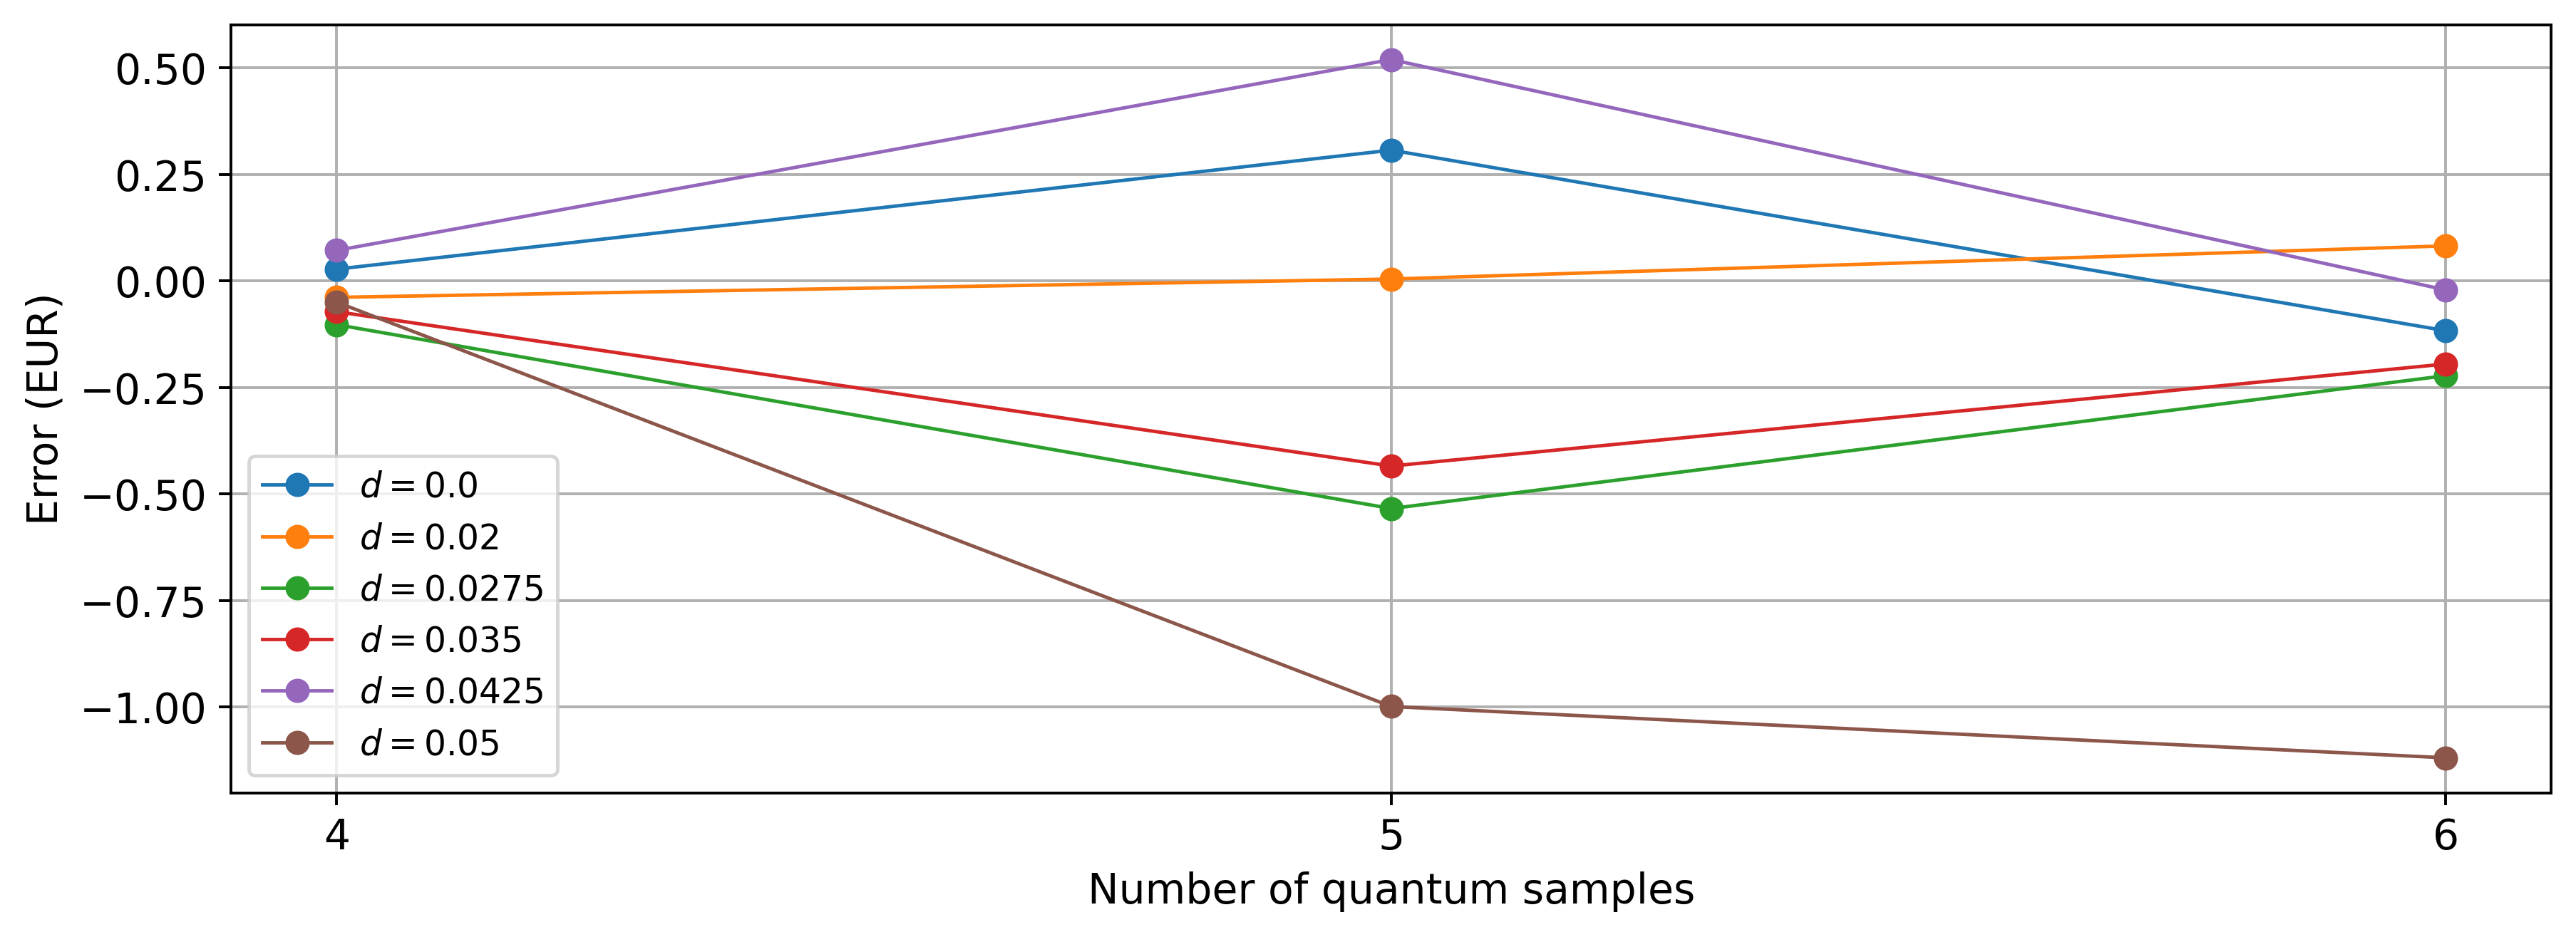

In [263]:
df_eval_errors.columns = columns_name
fig, axs = plt.subplots(figsize=(12, 4), dpi=350)
df_eval_errors.plot(ax=axs, marker='o', markersize=6, linewidth=1, alpha=1)
axs.grid(True)
axs.tick_params(axis='both', labelsize=12)
axs.set_xticks(df_eval_errors.index)
axs.set_ylabel("Error (EUR)", fontsize=12)
axs.set_xlabel("Number of quantum samples",  fontsize=12)
plt.show()